In [0]:
%matplotlib inline
#from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math


try:
    import cPickle as pickle
except:
    import pickle

Some Utility Function

In [0]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)

#from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import sys

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
    
import torch.utils.data as data
from PIL import Image
import numpy as np
import h5py

In [0]:
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

In [0]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

In [0]:
class laplace_prior(object):
    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def loglike(self, x, do_sum=True):
        if do_sum:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b).sum()
        else:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b)

class isotropic_gauss_prior(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
        self.cte_term = -(0.5)*np.log(2*np.pi)
        self.det_sig_term = -np.log(self.sigma)

    def loglike(self, x, do_sum=True):
        
        dist_term = -(0.5)*((x - self.mu)/self.sigma)**2
        if do_sum:
            return (self.cte_term + self.det_sig_term + dist_term).sum()
        else:
            return (self.cte_term + self.det_sig_term + dist_term)
    

# TODO: adapt so can be done without sum
class spike_slab_2GMM(object):
    def __init__(self, mu1, mu2, sigma1, sigma2, pi):
        
        self.N1 = isotropic_gauss_prior(mu1, sigma1)
        self.N2 = isotropic_gauss_prior(mu2, sigma2)
        
        self.pi1 = pi 
        self.pi2 = (1-pi)

    def loglike(self, x):
        
        N1_ll = self.N1.loglike(x)
        N2_ll = self.N2.loglike(x)
        
        # Numerical stability trick -> unnormalising logprobs will underflow otherwise
        max_loglike = torch.max(N1_ll, N2_ll)
        normalised_like = self.pi1 + torch.exp(N1_ll - max_loglike) + self.pi2 + torch.exp(N2_ll - max_loglike)
        loglike = torch.log(normalised_like) + max_loglike
    
        return loglike
    

In [0]:
def isnan(tensor):
  # Gross: https://github.com/pytorch/pytorch/issues/4767
    return (tensor != tensor)

def hasnan(tensor):
    return isnan(tensor).any()

def isotropic_gauss_loglike(x, mu, sigma, do_sum=True):
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    
    if do_sum:
        out = (cte_term + det_sig_term + dist_term).sum() # sum over all weights
    else:
        out = (cte_term + det_sig_term + dist_term)
#     print(hasnan(x.data), hasnan(mu.data), hasnan(sigma.data), out)
#     if isnan(out) or hasnan(out):
#         print('NAaaanNNN')
#         print('mu max', mu.max())
#         print('mu min', mu.min())
#         print('sigma max', sigma.max())
#         print('sigma min', sigma.min())
#         print('x max', x.max())
#         print('x min', x.min())
#         print((x - mu).max())
#         print((x - mu).min())
#         print(hasnan(inner))
#         print(dist_term)
#         print(hasnan(dist_term))
    return out 



class BayesLinear_Normalq(nn.Module):
    def __init__(self, n_in, n_out, prior_class):
        super(BayesLinear_Normalq, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.prior = prior_class
        
        # Learnable parameters
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.2, 0.2))
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-3, -2))
        
        self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.2, 0.2))
        self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-3, -2))
        
       
        self.lpw = 0
        self.lqw = 0
        
                                   
    def forward(self, X, sample=False):
#         print(self.training)

        if not self.training and not sample: # This is just a placeholder function
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
            return output, 0, 0
                                       
        else:
                              
            # Tensor.new()  Constructs a new tensor of the same data type as self tensor. 
            # the same random sample is used for every element in the minibatch
            eps_W = Variable(self.W_mu.data.new(self.W_mu.size()).normal_())
            eps_b = Variable(self.b_mu.data.new(self.b_mu.size()).normal_())
                                       
            # sample parameters         
            
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
            std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)                      
                                   
            W = self.W_mu + 1 * std_w * eps_W
            b = self.b_mu + 1 * std_b * eps_b          
    
            
            output = torch.mm(X, W) + b.unsqueeze(0).expand(X.shape[0], -1) # (batch_size, n_output)
            
            lqw = isotropic_gauss_loglike(W, self.W_mu, std_w) + isotropic_gauss_loglike(b, self.b_mu, std_b)
            lpw = self.prior.loglike(W) + self.prior.loglike(b)
            return output, lqw, lpw


In [0]:
def sample_weights(W_mu, b_mu, W_p, b_p):
    
    eps_W = W_mu.data.new(W_mu.size()).normal_()
    # sample parameters         
    std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)     
    W = W_mu + 1 * std_w * eps_W
    
    if b_mu is not None:
        std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)  
        eps_b = b_mu.data.new(b_mu.size()).normal_()
        b = b_mu + 1 * std_b * eps_b
    else:
        b = None
    
    return W, b

In [0]:
class bayes_linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(bayes_linear_2L, self).__init__()
        
        n_hid = 400
#         prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
#         prior_instance = spike_slab_2GMM(mu1=0, mu2=0, sigma1=0.135, sigma2=0.001, pi=0.5)
        #self.prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        self.prior_instance = spike_slab_2GMM(0,1,0.5,1,0.5)
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bfc1 = BayesLinear_Normalq(input_dim, n_hid, self.prior_instance)
        self.bfc2 = BayesLinear_Normalq(n_hid, n_hid, self.prior_instance)
        self.bfc3 = BayesLinear_Normalq(n_hid, output_dim, self.prior_instance)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=False):
        
        tlqw = 0
        tlpw = 0
        
        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x, lqw, lpw = self.bfc1(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        x, lqw, lpw = self.bfc2(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        y, lqw, lpw = self.bfc3(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        
        return y, tlqw, tlpw
    
    def sample_predict(self, x, Nsamples):
        
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        tlqw_vec = np.zeros(Nsamples)
        tlpw_vec = np.zeros(Nsamples)
        
        for i in range(Nsamples):
            
            y, tlqw, tlpw = self.forward(x, sample=True)
            predictions[i] = y
            tlqw_vec[i] = tlqw
            tlpw_vec[i] = tlpw 
            
        return predictions, tlqw_vec, tlpw_vec

In [0]:
from __future__ import division
import copy

class Bayes_Net(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=1, side_in=28, cuda=True, classes=10, batch_size=128, Nbatches=0):
        super(Bayes_Net, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.classes = classes
        self.batch_size = batch_size
        self.Nbatches = Nbatches
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = bayes_linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y, samples=1):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        if samples == 1:
            out, tlqw, tlpw = self.model(x)
            mlpdw = F.cross_entropy(out, y, reduction='sum')
            Edkl = (tlqw - tlpw)/self.Nbatches
            
        elif samples > 1:
            mlpdw_cum = 0
            Edkl_cum = 0
            
            for i in range(samples):
                out, tlqw, tlpw = self.model(x, sample=True)
                mlpdw_i = F.cross_entropy(out, y, reduction='sum')
                Edkl_i = (tlqw - tlpw)/self.Nbatches
                mlpdw_cum = mlpdw_cum + mlpdw_i
                Edkl_cum = Edkl_cum + Edkl_i 
            
            mlpdw = mlpdw_cum/samples
            Edkl = Edkl_cum/samples
        
        loss = Edkl + mlpdw
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return Edkl.data, mlpdw.data, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    
    def get_weight_samples(self, Nsamples=10):
        state_dict = self.model.state_dict()
        weight_vec = []
        
        for i in range(Nsamples):
            previous_layer_name = ''
            for key in state_dict.keys():
                layer_name = key.split('.')[0]
                if layer_name != previous_layer_name:
                    previous_layer_name = layer_name

                    W_mu = state_dict[layer_name+'.W_mu'].data
                    W_p = state_dict[layer_name+'.W_p'].data

    #                 b_mu = state_dict[layer_name+'.b_mu'].cpu().data
    #                 b_p = state_dict[layer_name+'.b_p'].cpu().data

                    W, b = sample_weights(W_mu=W_mu, b_mu=None, W_p=W_p, b_p=None)

                    for weight in W.cpu().view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)
    
    def get_weight_SNR(self, thresh=None):
        state_dict = self.model.state_dict()
        weight_SNR_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                sig_W = 1e-6 + F.softplus(W_p, beta=1, threshold=20)

                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                sig_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                W_snr = (torch.abs(W_mu)/sig_W)
                b_snr = (torch.abs(b_mu)/sig_b)
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = W_snr > thresh
                    mask_dict[layer_name+'.b'] = b_snr > thresh
                    
                else:
                
                    for weight_SNR in W_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

                    for weight_SNR in b_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)
        
        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_SNR_vec)
    
    
    def get_weight_KLD(self, Nsamples=20, thresh=None):
        state_dict = self.model.state_dict()
        weight_KLD_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                
                std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)  
                std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                KL_W = W_mu.new(W_mu.size()).zero_()
                KL_b = b_mu.new(b_mu.size()).zero_()
                for i in range(Nsamples):
                    W, b = sample_weights(W_mu=W_mu, b_mu=b_mu, W_p=W_p, b_p=b_p)  
                    # Note that this will currently not work with slab and spike prior
                    KL_W += isotropic_gauss_loglike(W, W_mu, std_w, do_sum=False) - self.model.prior_instance.loglike(W, do_sum=False)
                    KL_b += isotropic_gauss_loglike(b, b_mu, std_b, do_sum=False) - self.model.prior_instance.loglike(b, do_sum=False)

                KL_W /= Nsamples
                KL_b /= Nsamples
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = KL_W > thresh
                    mask_dict[layer_name+'.b'] = KL_b > thresh
                    
                else:

                    for weight_KLD in KL_W.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

                    for weight_KLD in KL_b.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)
        
        if thresh is not None:
            return mask_dict
        else:    
            return np.array(weight_KLD_vec)
        
        
    def mask_model(self, Nsamples=0, thresh=0):
        '''
        Nsamples is used to select SNR (0) or KLD (>0) based masking
        '''
        original_state_dict = copy.deepcopy(self.model.state_dict())
        state_dict = self.model.state_dict()
        
        if Nsamples == 0:
            mask_dict = self.get_weight_SNR(thresh=thresh)
        else:
            mask_dict = self.get_weight_KLD(Nsamples=Nsamples, thresh=thresh)
        
        n_unmasked = 0
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name
                
                state_dict[layer_name+'.W_mu'][1-mask_dict[layer_name+'.W']] = 0
                state_dict[layer_name+'.W_p'][1-mask_dict[layer_name+'.W']] = -1000
                
                state_dict[layer_name+'.b_mu'][1-mask_dict[layer_name+'.b']] = 0
                state_dict[layer_name+'.b_p'][1-mask_dict[layer_name+'.b']] = -1000
                
                
                n_unmasked += mask_dict[layer_name+'.W'].sum()
                n_unmasked += mask_dict[layer_name+'.b'].sum()
                
        return original_state_dict, n_unmasked
            


Data:

Network:

Net:
 Creating Net!! 
    Total params: 0.96M

Train:
  init cost variables:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


it 0/100, Jtr_KL = 11.090269, Jtr_pred = 1.284238, err = 0.220350,    time: 31.613770 seconds

    Jdev = 0.255116, err = 0.075900

it 1/100, Jtr_KL = 11.084159, Jtr_pred = 0.391667, err = 0.113083,    time: 31.715090 seconds

    Jdev = 0.187477, err = 0.054800

it 2/100, Jtr_KL = 11.076904, Jtr_pred = 0.310054, err = 0.088417,    time: 31.645343 seconds

    Jdev = 0.162079, err = 0.047800

it 3/100, Jtr_KL = 11.069387, Jtr_pred = 0.265415, err = 0.077083,    time: 31.684786 seconds

    Jdev = 0.141215, err = 0.041000

it 4/100, Jtr_KL = 11.061975, Jtr_pred = 0.236580, err = 0.069733,    time: 31.536874 seconds

    Jdev = 0.132129, err = 0.038500

it 5/100, Jtr_KL = 11.054317, Jtr_pred = 0.218825, err = 0.064633,    time: 31.617740 seconds

    Jdev = 0.122440, err = 0.036400

it 6/100, Jtr_KL = 11.046373, Jtr_pred = 0.200730, err = 0.057667,    time: 31.543131 seconds

    Jdev = 0.120792, err = 0.036600

it 7/100, Jtr_KL = 11.038732, Jtr_pred = 0.185125, err = 0.054083,    time: 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type bayes_linear_2L. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BayesLinear_Normalq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 600x400 with 0 Axes>

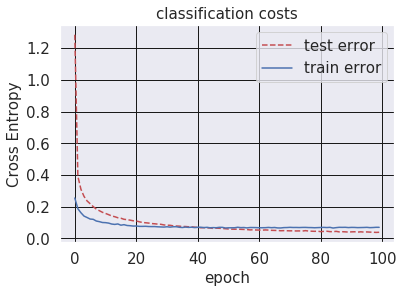

<Figure size 432x288 with 0 Axes>

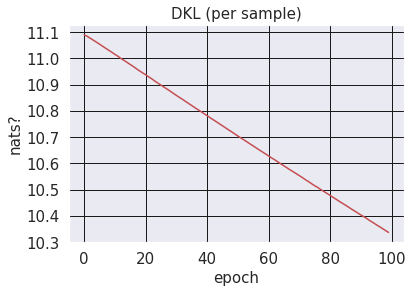

<Figure size 600x400 with 0 Axes>

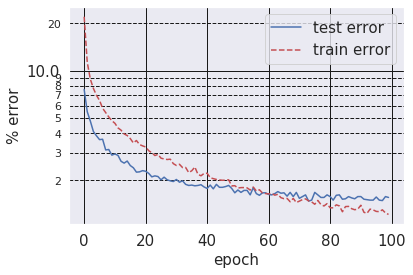

In [0]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib
import copy


#models_dir = 'models_weight_uncertainty_MC_MNIST_gaussian'
#results_dir = 'results_weight_uncertainty_MC_MNIST_gaussian'

#mkdir(models_dir)
#mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 128
nb_epochs = 100
log_interval = 1

savemodel_its = [20, 50, 80, 120]
save_dicts = []

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-3
nsamples = 3
########################################################################################
net = Bayes_Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))

epoch = 0

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_dkl, cost_pred, err = net.fit(x, y, samples=nsamples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # Save state dict
    
    #if i in savemodel_its:
    #    save_dicts.append(copy.deepcopy(net.model.state_dict()))
    
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        #if err_dev[i] < best_err:
         #   best_err = err_dev[i]
         #   cprint('b', 'best test error')
          #  net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', kl_cost_train)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')

In [0]:
len(trainset)

60000

In [0]:
pip install mnist

In [0]:
from keras.optimizers import SGD
import numpy as np
import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 126) - 0.5
test_images = (test_images / 126) - 0.5

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

baseline_model = Sequential([
  Dense(400, activation='relu', input_shape=(784,)),
  Dense(400, activation='relu'),  
  Dense(10, activation='softmax'),
])

baseline_model.compile(optimizer=SGD(lr=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

baseline_model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                4010      
Total params: 478,410
Trainable params: 478,410
Non-trainable params: 0
_________________________________________________________________


In [0]:
baseline_history = baseline_model.fit(train_images,
                                      to_categorical(train_labels),
                                      epochs=100,
                                      batch_size=128,
                                      validation_data=(test_images,
                                                      to_categorical(test_labels)))





Train on 60000 samples, validate on 10000 samples
Epoch 1/100





60000/60000 [==============================] - 6s 107us/step - loss: 0.3256 - acc: 0.9000 - val_loss: 0.3151 - val_acc: 0.9000
Epoch 2/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.3067 - acc: 0.9000 - val_loss: 0.2976 - val_acc: 0.9000
Epoch 3/100
60000/60000 [==============================] - 3s 44us/step - loss: 0.2907 - acc: 0.9000 - val_loss: 0.2818 - val_acc: 0.9000
Epoch 4/100
60000/60000 [==============================] - 3s 44us/step - loss: 0.2757 - acc: 0.9000 - val_loss: 0.2668 - val_acc: 0.9002
Epoch 5/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.2613 - acc: 0.9005 - val_loss: 0.2523 - val_acc: 0.9010
Epoch 6/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.2474 - acc: 0.9020 - val_loss: 0.2382 - val_acc: 0.9037
Epoch 7/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.2338 - acc: 0.9059 - val_loss: 

In [0]:
from numpy  import array
data_acc=baseline_history.history['val_acc']
type(data_acc)
a = array( data_acc )
acc_sgd= 1-a

In [0]:
acc_sgd

array([0.10000002, 0.10000002, 0.09999002, 0.09980002, 0.09896   ,
       0.09629001, 0.09172002, 0.08644003, 0.08119004, 0.07600003,
       0.07099003, 0.06602002, 0.06162001, 0.05807001, 0.05479001,
       0.05117001, 0.04803001, 0.04533001, 0.04288001, 0.04065   ,
       0.03865   , 0.03689   , 0.0353    , 0.034     , 0.03276   ,
       0.03163   , 0.03062   , 0.02991   , 0.02911999, 0.02826   ,
       0.02767999, 0.02696999, 0.02652   , 0.02606999, 0.02566999,
       0.02520999, 0.02491999, 0.02455999, 0.02421999, 0.02407999,
       0.02371   , 0.02354999, 0.02325999, 0.02300999, 0.02273999,
       0.02243   , 0.02214   , 0.02184   , 0.02156999, 0.02156999,
       0.02133999, 0.02115   , 0.02109999, 0.02090999, 0.02076   ,
       0.02058   , 0.02045   , 0.02023   , 0.02012   , 0.01996   ,
       0.01979   , 0.01974999, 0.01968   , 0.01959   , 0.01946   ,
       0.01935   , 0.01929   , 0.01921   , 0.01914   , 0.01903   ,
       0.01891   , 0.01883   , 0.01874   , 0.01868   , 0.01859

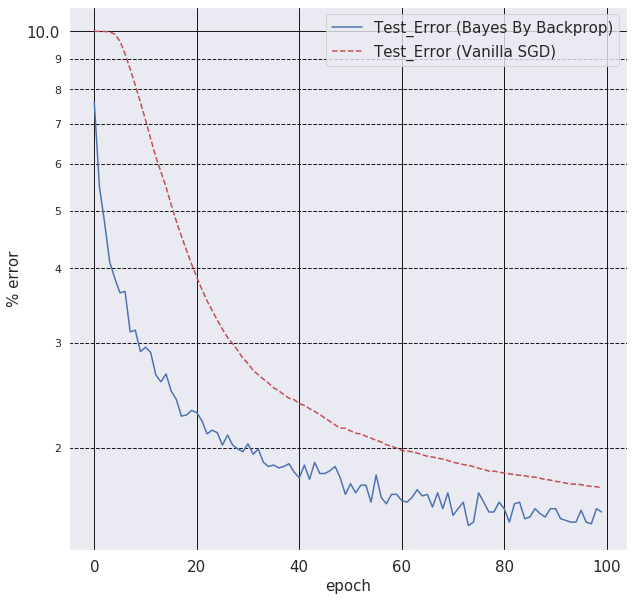

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
textsize = 15
marker=20
#plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * acc_sgd, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['Test_Error (Bayes By Backprop)', 'Test_Error (Vanilla SGD)'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


RESULTS:
  cost_dev: 0.068071 (cost_train 0.038630)
  err_dev: 0.016300
  nb_parameters: 956820 (934.39KB)
  time_per_it: 39.844658s



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


<Figure size 600x400 with 0 Axes>

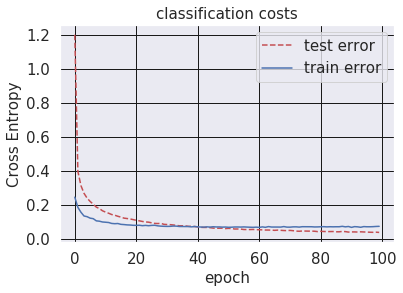

<Figure size 432x288 with 0 Axes>

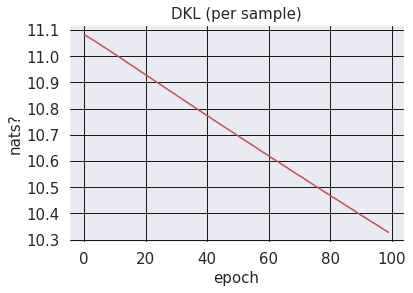

<Figure size 600x400 with 0 Axes>

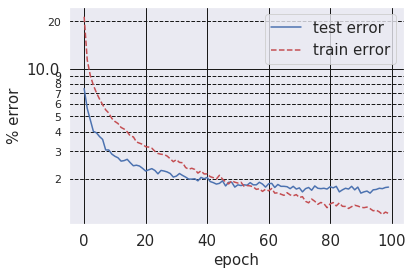

In [0]:
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', kl_cost_train)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


In [0]:
nb_its_dev

1

In [0]:
err_dev[::nb_its_dev]

array([0.0749, 0.056 , 0.0474, 0.0401, 0.0393, 0.0372, 0.0357, 0.0306,
       0.0306, 0.0288, 0.0279, 0.0273, 0.026 , 0.0262, 0.0267, 0.0254,
       0.0243, 0.0245, 0.0242, 0.0234, 0.0225, 0.0229, 0.0233, 0.0227,
       0.0216, 0.0227, 0.0225, 0.0222, 0.0217, 0.0206, 0.0209, 0.0217,
       0.0211, 0.0206, 0.02  , 0.02  , 0.0201, 0.0195, 0.0205, 0.0201,
       0.0205, 0.0193, 0.019 , 0.0186, 0.0188, 0.0195, 0.0181, 0.0191,
       0.0191, 0.0178, 0.0184, 0.0182, 0.0184, 0.0183, 0.019 , 0.0184,
       0.0184, 0.0191, 0.0186, 0.0178, 0.0187, 0.0188, 0.0177, 0.0185,
       0.018 , 0.018 , 0.0179, 0.0174, 0.018 , 0.0173, 0.0176, 0.0166,
       0.0174, 0.0177, 0.017 , 0.0181, 0.0175, 0.0174, 0.0175, 0.0173,
       0.0179, 0.0176, 0.018 , 0.0166, 0.0171, 0.0175, 0.0173, 0.018 ,
       0.0171, 0.0178, 0.0163, 0.0166, 0.0168, 0.0163, 0.0171, 0.0172,
       0.0175, 0.0174, 0.0177, 0.0178])

In [0]:
err_dev[::nb_its_dev]
baseline_history.history['val_loss']

NameError: ignored

In [0]:
models_dir = 'models_weight_uncertainty_MC_MNIST_gaussian'
results_dir = 'results_weight_uncertainty_MC_MNIST_gaussian'

mkdir(models_dir)
mkdir(results_dir)

(4776000,)


Text(0.5, 1.0, 'Total parameters: 477600, samples: 10')

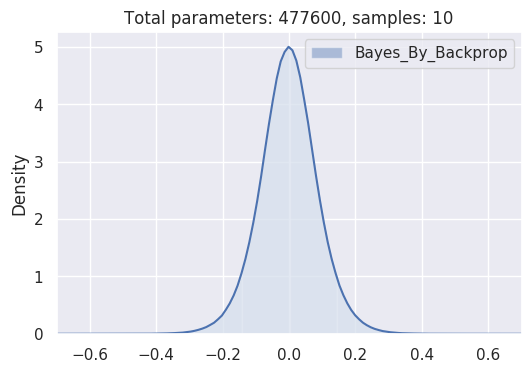

In [0]:
name = 'Bayes_By_Backprop'
Nsamples = 10
weight_vector = net.get_weight_samples(Nsamples=Nsamples)
np.save(results_dir+'/weight_samples_'+name+'.npy', weight_vector)

print(weight_vector.shape)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
symlim = 0.7

lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))

sns.distplot(weight_vector, 500, norm_hist=False, label=name, ax=ax)
ax.set_xlim((-symlim, symlim))
# ax.hist(weight_vector, bins=70, density=True);

ax.set_ylabel('Density')
ax.legend()
plt.title('Total parameters: %d, samples: %d' % (len(weight_vector)/Nsamples, Nsamples))

In [0]:
last_state_dict = copy.deepcopy(net.model.state_dict())
savemodel_its = [20, 50, 80, 90]
Nsamples = 10

for idx, iteration in enumerate(savemodel_its):
    
    net.model.load_state_dict(save_dicts[idx])
    weight_vector = net.get_weight_samples(Nsamples=Nsamples)
    fig = plt.figure(dpi=120)
    ax = fig.add_subplot(111)
    symlim = 1
    lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))
    sns.distplot(weight_vector, 350, norm_hist=False, label='it %d' % (iteration), ax=ax)
    ax.legend()

    ax.set_xlim((-symlim, symlim))


net.model.load_state_dict(last_state_dict)

IndexError: ignored

In [0]:
net.model.load_state_dict(save_dicts[2])

IndexError: ignored

(4776000,)


Text(0.5, 1.0, 'Total parameters: 477600, samples: 10')

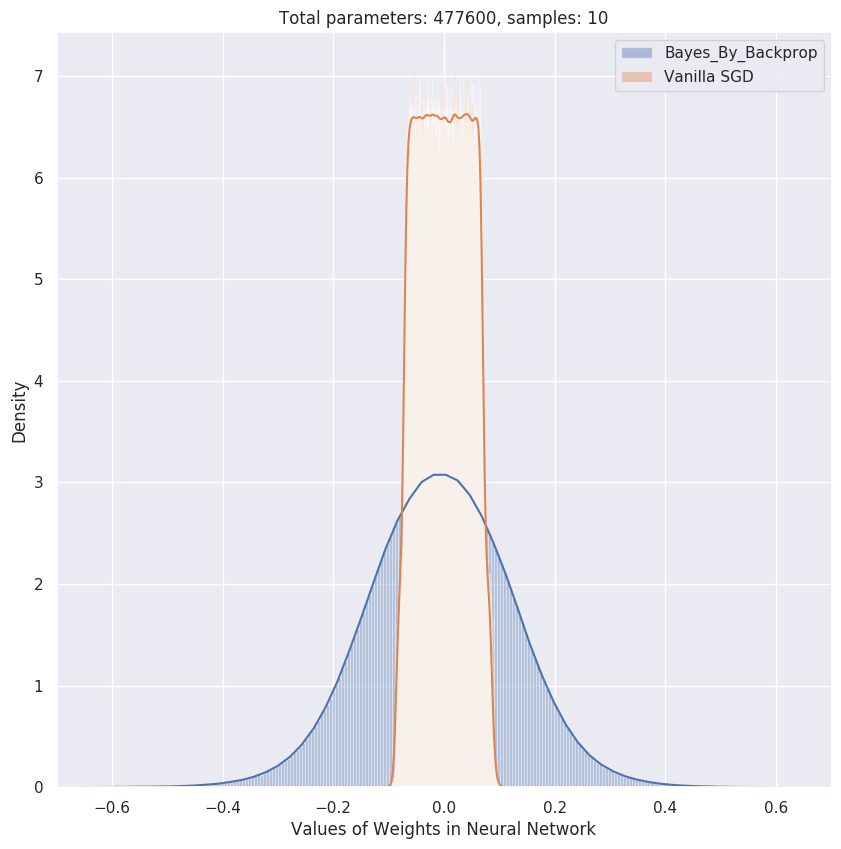

In [0]:
name1 = 'Bayes_By_Backprop'
name2 = 'Vanilla SGD'
Nsamples = 10
weight_vector = net.get_weight_samples(Nsamples=Nsamples)
np.save(results_dir+'/weight_samples_'+name+'.npy', weight_vector)

print(weight_vector.shape)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
symlim = 0.7

lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))

sns.distplot(weight_vector, 500, norm_hist=False, label=name1, ax=ax)
sns.distplot(Weights, 500, norm_hist=False, label=name2, ax=ax)
ax.set_xlim((-symlim, symlim))
# ax.hist(weight_vector, bins=70, density=True);

ax.set_ylabel('Density')
ax.set_xlabel('Values of Weights in Neural Network')
ax.legend()
plt.title('Total parameters: %d, samples: %d' % (len(weight_vector)/Nsamples, Nsamples))

In [0]:
len(weight_vector)

4776000

In [0]:
weigh=baseline_model.layers[1].get_weights()[0][398]
len(weigh)
weigh[0]

0.009048584

In [0]:
new1=[]
for i in range(0,784):
  mylist = baseline_model.layers[0].get_weights()[0][i]
  new1=np.append(new1, mylist)
len(new1)

313600

In [0]:
new2=[]
for i in range(0,399):
  mylist = baseline_model.layers[1].get_weights()[0][i]
  new2=np.append(new2, mylist)
len(new2)

159600

In [0]:
Weights = np.append(new1,new2)
len(Weights)

473200

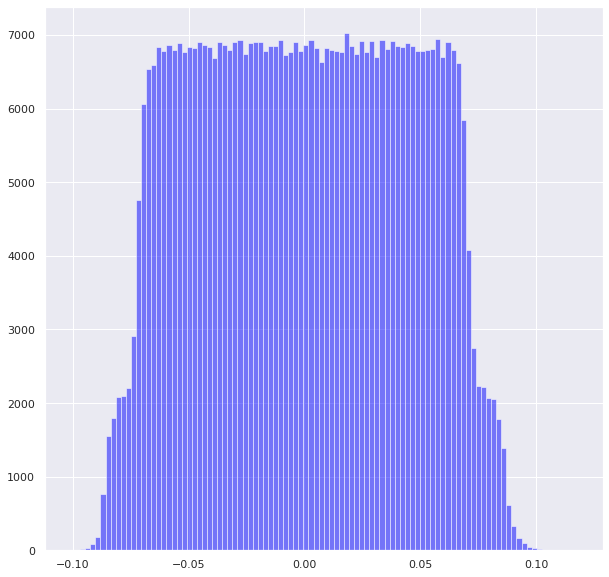

In [0]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(Weights, num_bins, facecolor='blue', alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Total parameters: 47320, samples: 10')

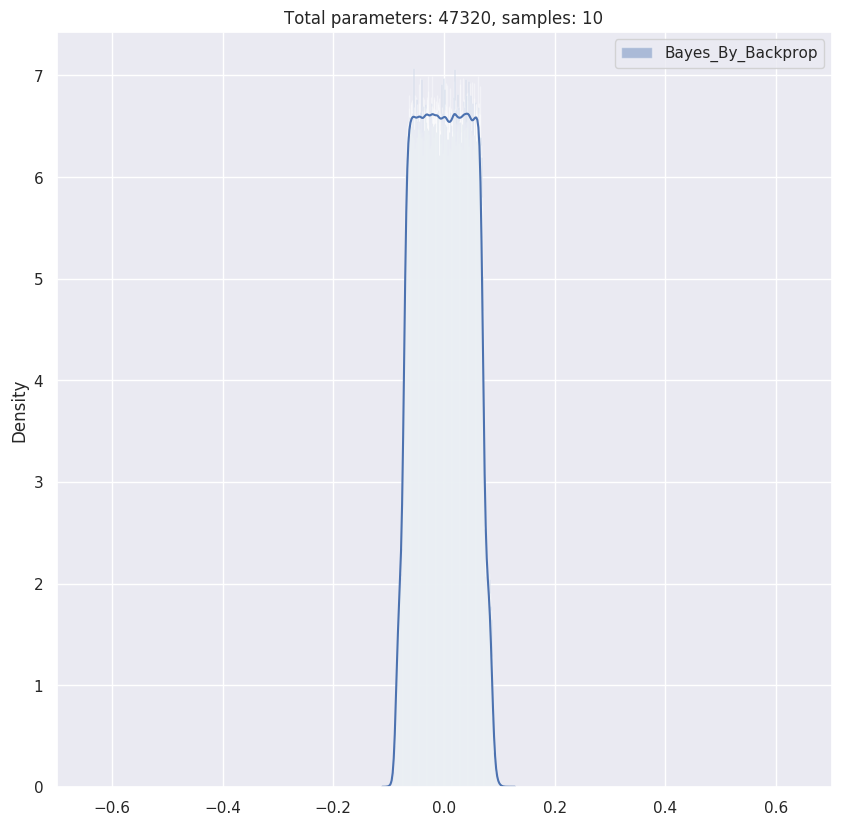

In [0]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
symlim = 0.7

lim_idxs = np.where(np.logical_and(Weights>=symlim, Weights<=symlim))

sns.distplot(Weights, 500, norm_hist=False, label=name, ax=ax)
ax.set_xlim((-symlim, symlim))
# ax.hist(weight_vector, bins=70, density=True);

ax.set_ylabel('Density')
ax.legend()
plt.title('Total parameters: %d, samples: %d' % (len(Weights)/Nsamples, Nsamples))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


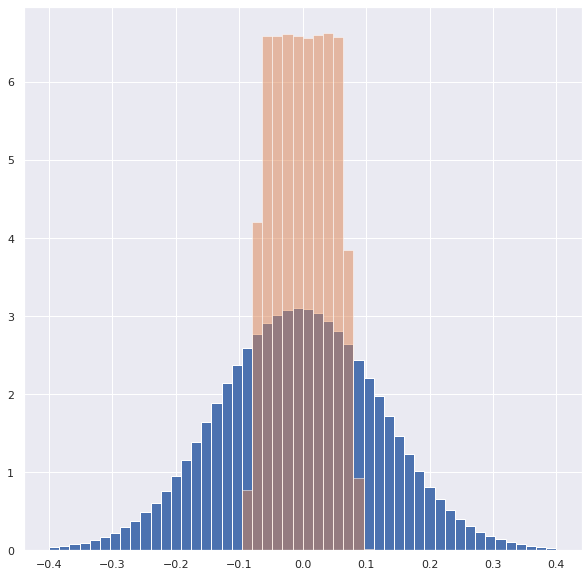

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#foo = np.random.normal(loc=1, size=100) # a normal distribution
#bar = np.random.normal(loc=-1, size=10000) # a normal distribution

_, bins, _ = plt.hist(weight_vector, bins=50, range=[-0.4, 0.4], normed=True)
_ = plt.hist(Weights, bins=bins, alpha=0.5, normed=True)


AttributeError: ignored

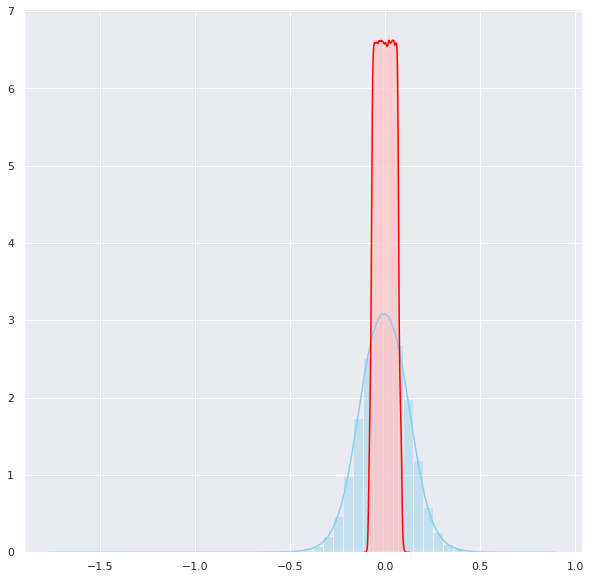

In [0]:
import seaborn as sns
sns.distplot( weight_vector , color="skyblue", label="Sepal Length")
sns.distplot( Weights , color="red", label="Sepal Width")
sns.plt.legend()
 